In [1]:
from pseudo_povm_circuits import *
import cmath
import math
import random
import matplotlib.pyplot as plt

In [2]:
#Define SIC-POVM
sic_ten = tf.constant([[1/4,1/4,1/4],
                       [-math.sqrt(3)/12, math.sqrt(3)/12, math.sqrt(3)/12],
                       [math.sqrt(3)/12, -math.sqrt(3)/12, math.sqrt(3)/12],
                       [math.sqrt(3)/12, math.sqrt(3)/12, -math.sqrt(3)/12]],
                      dtype = tf.float64)
sic_povm = PseudoPovm(sic_ten)

In [3]:
def generate_random_pseudo_povm():
  '''Generates random pseudo POVM

  Returns instance of PseudoPovm class
  '''
  
  povm_ten = tf.random.normal([4, 3], dtype = tf.float64)
  return PseudoPovm(povm_ten)

In [4]:
def total_negativity_optimization(circuit):
  '''Finds pseudo POVM where total negativity of given circuit is minimal

  Arguments
  ---------
  circuit : QubitCircuit 

  Returns instance of class PseudoPovm
  '''


  #=========================#
  lr = 0.01 # learning rate
  #=========================#
  opt = tf.keras.optimizers.Adagrad(lr)

  def neg(var):
    povm = PseudoPovm(var)
    return circuit.total_negativity(povm) 

  povm = sic_povm


  var = povm.lam
  var = tf.Variable(var)


  #print(neg(var))

  for i in range(2500):
    with tf.GradientTape() as tape:

      loss = neg(var)
    grad = tape.gradient(loss, var) 
    opt.apply_gradients(zip([grad], [var]))  # minimization step
  
  lam = tf.complex(var,tf.zeros([4, 3], dtype = tf.float64))
  return PseudoPovm(lam)

In [5]:
# Initialize some single qubit gates
X = sigma_x
Y = sigma_y
Z = sigma_z
T = tf.constant([[1 ,0],[0, cmath.exp(1j * math.pi / 4)]], dtype=tf.complex128)
H = tf.constant([[1,1],[1,-1]], dtype=tf.complex128) / math.sqrt(2)
S = tf.constant([[1,0],[0,1j]],dtype=tf.complex128)

In [6]:
#In this example we consider only gates from clifford group
clifford_group = [T,S,H]

In [7]:
#Let's define set of pauli matrixes
pauli = [X,Y,Z]

In [8]:
def get_circuits_difference(gates_num):
  """
  Calculates difference between fair circuit and its 
  stochastic approximation for given number of gates

  Arguments
  ---------
  gates_num number of gates

  Returns 
  -------
  difference in sic_povm
  difference in optimal pseudo povm
  """
  gates = []
  for i in range(gates_num):
    gates.append(random.choice(pauli))
  circuit = QubitCircuit(gates)
  best_basis = total_negativity_optimization(circuit)
  fair_opt_res = circuit.run_circuit(best_basis)
  approx_opt_res = circuit.run_approx_circuit(best_basis)
  fair_sic_res = circuit.run_circuit(sic_povm)
  approx_sic_res = circuit.run_approx_circuit(sic_povm)
  sic_diff = tf.linalg.norm(fair_sic_res - approx_sic_res, ord = 1)
  opt_diff = tf.linalg.norm(fair_opt_res - approx_opt_res, ord = 1)
  return sic_diff, opt_diff


In [9]:
def get_negativity(gates_num):
  """
  Calculates negativity for random circuits

  Arguments
  ---------
  gates_num number of gates

  Returns 
  -------
  negativity in sic povm
  negativity in optimal pseudo povm
  """
  gates = []
  for i in range(gates_num):
    gates.append(random.choice(pauli))
  circuit = QubitCircuit(gates)
  opt_basis = total_negativity_optimization(circuit)
  return circuit.total_negativity(sic_povm), circuit.total_negativity(opt_basis)


In [10]:
x = np.arange(3,8)
y = np.zeros([len(x),2])
for i in range(len(x)):
  y[i] = get_circuits_difference(x[i])

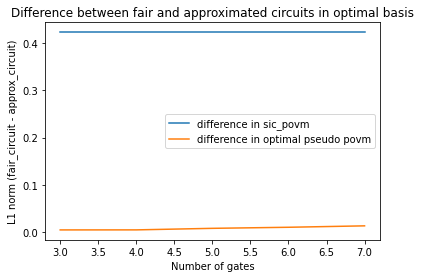

In [11]:
plt.plot(x,y[:,0],label = 'difference in sic_povm')
plt.plot(x,y[:,1],label = 'difference in optimal pseudo povm')
plt.title('Difference between fair and approximated circuits in optimal basis')
plt.ylabel('L1 norm (fair_circuit - approx_circuit)')
plt.xlabel('Number of gates')
plt.legend()
plt.show()

In [12]:
y_neg = np.zeros([len(x),2])
for i in range(len(x)):
  y_neg[i] = get_negativity(x[i])

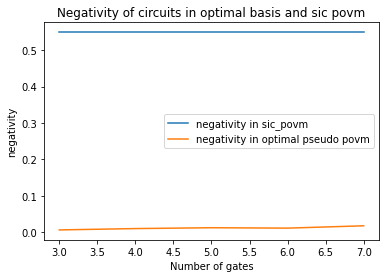

In [13]:
plt.plot(x,y_neg[:,0],label = 'negativity in sic_povm')
plt.plot(x,y_neg[:,1],label = 'negativity in optimal pseudo povm')
plt.title('Negativity of circuits in optimal basis and sic povm')
plt.ylabel('negativity')
plt.xlabel('Number of gates')
plt.legend()
plt.show()